# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Feature engineering
4. Modelling

---

## 1. Import packages

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

---
## 2. Load data

In [4]:
df = pd.read_csv('./client_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [5]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

As we have seen in the EDA, the price features has really low correlation with churn, so we will create some different features.

### Tenure

How long a company has been a client of PowerCo.

Although we have one variable called num_years_antig, we found it's not absolute accurate, so we will re-process the data to get the accurate tenure of each client.

In [6]:
df['tenure'] =((df['date_end'] - df['date_activ']) / np.timedelta64(1, 'Y')).astype(int)

In [7]:
df.groupby('tenure').agg({'id': 'count', 'churn':'mean'}).sort_values(by = 'churn', ascending = False)

,id,churn
tenure,,
3,1169,0.143713
2,263,0.133080
4,3801,0.125756
13,42,0.095238
5,3067,0.085425
12,132,0.083333
6,3085,0.080713
7,2616,0.073394
11,173,0.063584


As we can see, clients who have been with this company for less than 4 years are more likely to churn compared to clients who have longer tenure. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer.

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

### Transforming dates into months

Dates as a datetime object are not useful for a predictive model, so transforming dates into months which become a interval variable which may hold more predictive power.

Here I transformed three dates to month until the reference date - Jan 2016, which is the end date of this dataset.

- months_activ = Number of months active until reference date (Jan 2016)
As we have seen earlier, the longer a client has been with this company, the less likely they will churn. Hence, we add month_activ feature.

- months_to_end = Number of months of the contract left until reference date (Jan 2016)
When the client's contract has coming to the end, client need to make a choice of stay or switch supplier, so it is interesting to keep this feature as it may reveal patterns and behaviours about timing of churn.

- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
When the client has recently modify their product package, it may mean they are engaged clients which like upgrading or try different product of this company. 



I did not use date_renewal to create new feature because the date_renewal is just the last renewal date which is just the same date of their active date but in year 2015. We cannot gain much useful information from this vairable.

In [8]:
# Create a function to convert the date into month
def convert_month(reference_date, df, cols):
   
    month = ((pd.to_datetime(reference_date) - df[cols]) / np.timedelta64(1, 'M')).astype(int)
    return month   
     


In [9]:
# Create reference date
reference_date = datetime(2016, 1, 1)

df['months_activ'] = convert_month(reference_date, df, 'date_activ')
df['months_to_end'] =  -convert_month(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_month(reference_date, df, 'date_modif_prod')

In [10]:
print(df.loc[:, ['months_activ', 'months_to_end', 'months_modif_prod']])

       months_activ  months_to_end  months_modif_prod
0                30              5                  2
1                76              7                 76
2                68              3                 68
3                69              2                 69
4                71              2                 71
...             ...            ...                ...
14601            43              4                  7
14602            40              7                 40
14603            46              1                 46
14604            40              7                 40
14605            72             11                 72

[14606 rows x 3 columns]


In [11]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,tenure,months_activ,months_to_end,months_modif_prod
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,3,30,5,2
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,7,76,7,76
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,6,68,3,68
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0,6,69,2,69
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0,6,71,2,71


### Transforming Boolean data

#### has_gas

Transform this column from categorical data to binary data (0,1)
Seems like clients who uses gas from PowerCo are less likely to churn compared to others who does not use gas.

In [12]:
df['has_gas'] = df['has_gas'].replace(['t','f'], [1, 0])
df.groupby('has_gas')['churn'].mean()

has_gas
0    0.100544
1    0.081856
Name: churn, dtype: float64

### Transforming categorical data

Another important step before building the predictive model is to transform categorical data into dummy variables (One hot encoding), which will create a new feature for every unique category and fill this column with 1 or 0 to indicate the client does or does not belong to this category.

#### channel_sales

In [13]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [14]:
categories_channel = pd.get_dummies(df['channel_sales'], prefix = 'channel')
categories_channel.columns = [col[:12] for col in categories_channel.columns]
# Merge it back to the dataframe
df = df.join(categories_channel)

The last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all.
For this reason, these 3 dummy variables are dropped.

In [15]:
df = df.drop(columns=['channel_sddi', 'channel_epum', 'channel_fixd', 'channel_sales'])

#### origin_up

In [16]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [17]:
categories_origin = pd.get_dummies(df['origin_up'], prefix = 'origin')
categories_origin.columns = [col[:10] for col in categories_origin.columns]

In [18]:
df = df.join(categories_origin)

In [19]:
df.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'tenure', 'months_activ', 'months_to_end', 'months_modif_prod',
       'channel_MISS', 'channel_ewpa', 'channel_foos', 'channel_lmke',
       'channel_usil', 'origin_MIS', 'origin_ewx', 'origin_kam', 'origin_ldk',
       'origin_lxi', 'origin_usa'],
      dtype='object')

For same reason, we drop three least value count dummy varibles in origin_up

In [20]:
df = df.drop(columns=['origin_MIS', 'origin_usa', 'origin_ewx', 'origin_up'])

In [21]:
df

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_to_end,months_modif_prod,channel_MISS,channel_ewpa,channel_foos,channel_lmke,channel_usil,origin_kam,origin_ldk,origin_lxi
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,5,2,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,7,76,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,3,68,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,2,69,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,2,71,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14601,18463073fb097fc0ac5d3e040f356987,32270,47940,0,4648.01,0,0.0,18.57,0.138305,0.000000,...,4,7,0,0,1,0,0,0,0,1
14602,d0a6f71671571ed83b2645d23af6de00,7223,0,181,631.69,181,0.0,144.03,0.100167,0.091892,...,7,40,0,0,1,0,0,0,0,1
14603,10e6828ddd62cbcf687cb74928c4c2d2,1844,0,179,190.39,179,0.0,129.60,0.116900,0.100015,...,1,46,0,0,1,0,0,0,0,1
14604,1cf20fd6206d7678d5bcafd28c53b4db,131,0,0,19.34,0,0.0,7.18,0.145711,0.000000,...,7,40,0,0,1,0,0,0,0,1


### Transforming numerical data

In EDA we have seen the consumption and forecast variables are highly positive skewed, before building the predictive models, we need to try transform those data to see if they are independent and normally distributed. As the models have parametric assumptions. 

For this use case we will use the 'Logarithm' transformation for the positively skewed features. 

Because we cannot apply log to a value of 0, so we will add a constant of 1 to all the values

First I want to see the statistics of the skewed features, so that we can compare before and after transformation

In [22]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


We can see that the standard deviation for most of these features is quite high.

In [23]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [24]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


We can see after transform the standard deviation is much smaller.
Let's plot the histogram 

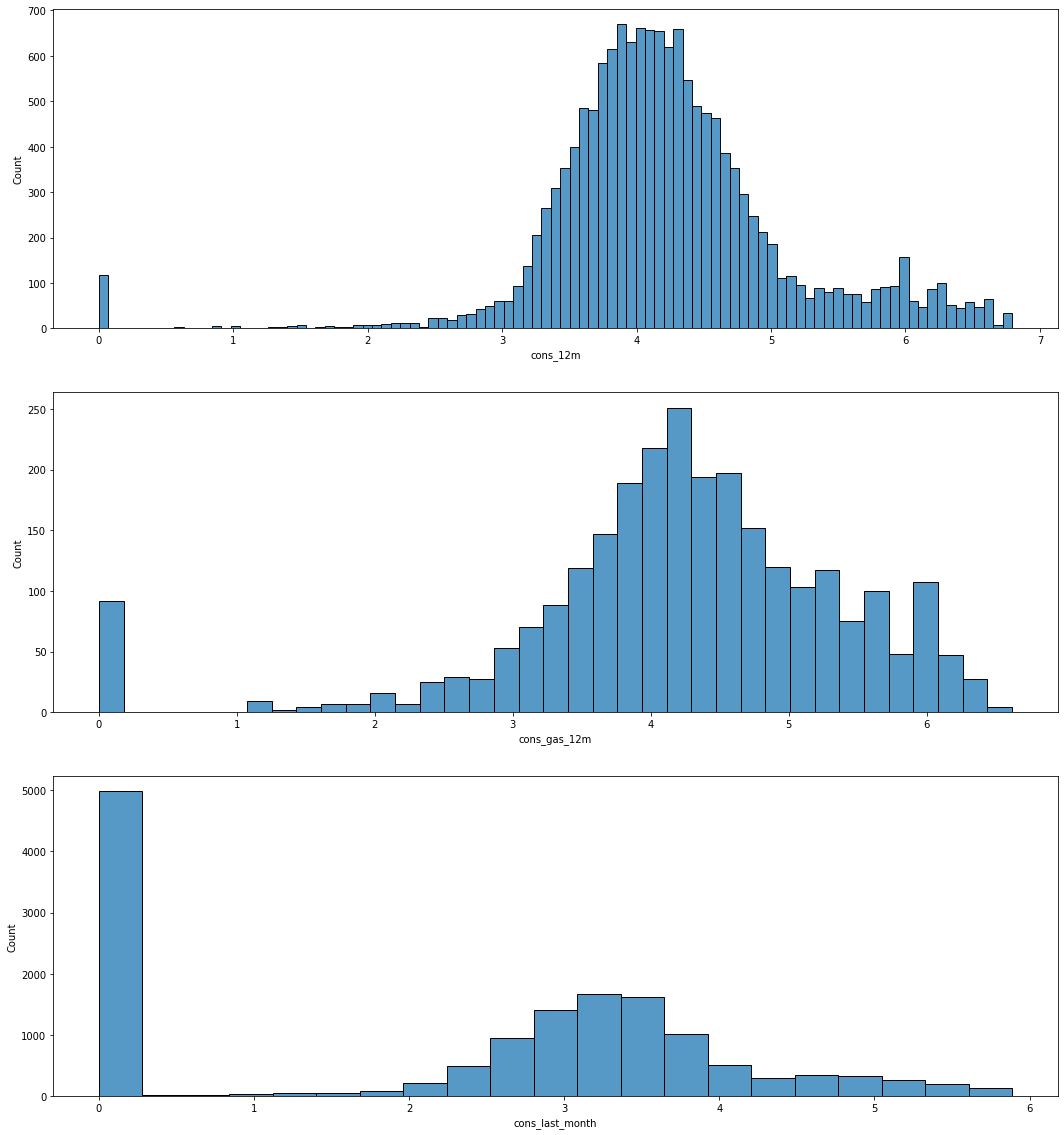

In [25]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.histplot((df["cons_12m"].dropna()), ax=axs[0])
sns.histplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.histplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

Histogram shows it normal distribution

### Correlations

In terms of creating new features and transforming existing ones, it is very much a trial and error situation that requires iteration. Once we train a predictive model we can see which features work and don't work, we will also know how predictive this set of features is. Based on this, we can come back to feature engineering to enhance our model. 

For now, we will leave feature engineering at this point. Another thing that is always useful to look at is how correlated all of the features are within your dataset.

This is important because it reveals the linear relationships between features. We want features to correlate with `churn`, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information. One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption. 

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [26]:
correlation = df.corr()
correlation.head()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_to_end,months_modif_prod,channel_MISS,channel_ewpa,channel_foos,channel_lmke,channel_usil,origin_kam,origin_ldk,origin_lxi
cons_12m,1.000000,0.209637,0.623493,0.557186,0.321928,-0.028437,0.201488,-0.144678,0.277831,-0.162694,...,-0.094377,0.074155,-0.084505,-0.064549,-0.021040,0.300029,-0.125876,0.032191,-0.026175,-0.006561
cons_gas_12m,0.209637,1.000000,0.171077,0.108450,0.084575,0.001444,0.063462,-0.041916,0.075684,-0.030439,...,0.009399,0.019233,0.030565,-0.008177,-0.046458,0.048664,-0.014001,0.000443,0.001582,-0.002899
cons_last_month,0.623493,0.171077,1.000000,0.292725,0.786051,-0.015106,0.326362,-0.236935,0.396657,-0.162611,...,-0.087789,0.065223,-0.058077,-0.066062,0.010777,0.205685,-0.111115,-0.031805,-0.023550,0.049516
forecast_cons_12m,0.557186,0.108450,0.292725,1.000000,0.361325,0.056053,0.222187,0.047935,0.220189,0.101439,...,-0.090652,-0.104551,-0.099932,-0.006704,0.055963,0.081416,-0.034369,-0.031513,-0.020166,0.046185
forecast_cons_year,0.321928,0.084575,0.786051,0.361325,1.000000,0.014451,0.391082,-0.296602,0.431537,-0.194797,...,-0.058543,-0.009869,-0.035257,-0.034238,0.057864,0.038128,-0.062021,-0.097037,-0.012083,0.099111


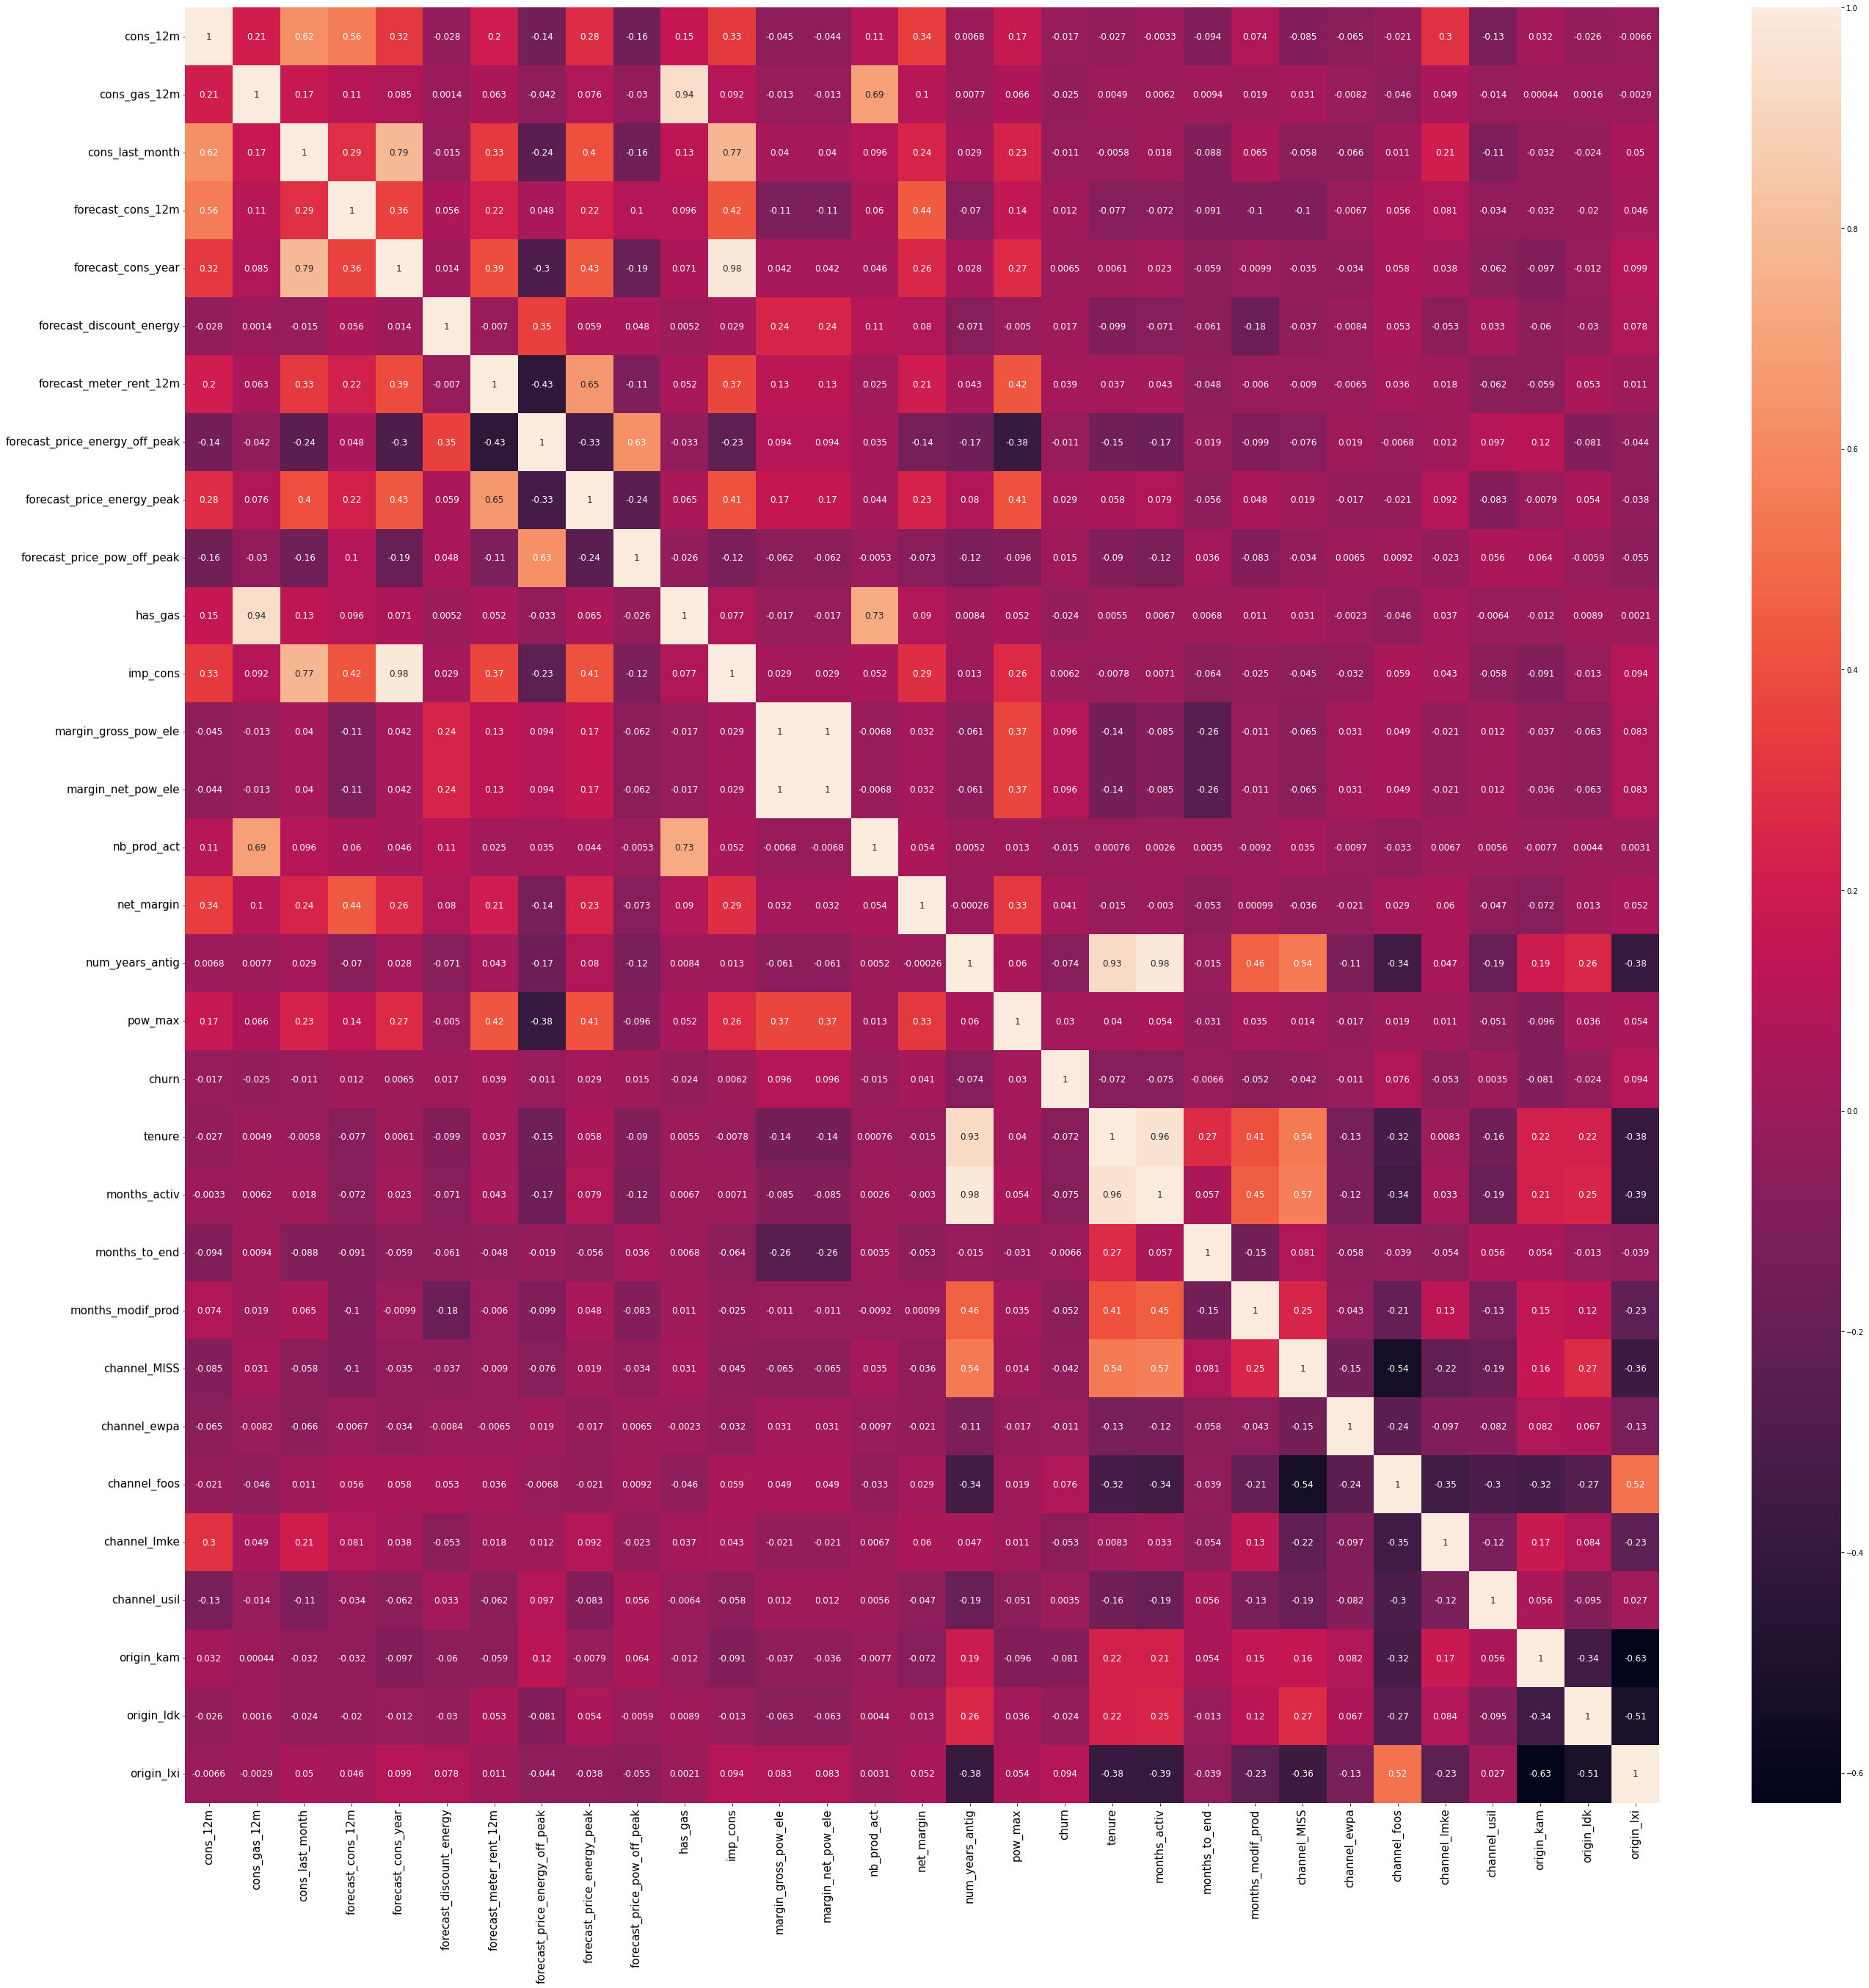

In [27]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Selecting features based on correlation
Dropped variables which exhibit a high correlation (>0.9) with other independent features.

In [28]:
df = df.drop(columns=['num_years_antig','tenure', 'forecast_cons_year', 'has_gas'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_to_end,months_modif_prod,channel_MISS,channel_ewpa,channel_foos,channel_lmke,channel_usil,origin_kam,origin_ldk,origin_lxi
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,5,2,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,7,76,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,3,68,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,2,69,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,2,71,1,0,0,0,0,1,0,0


---

## 5. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [29]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### Data Sampling

Split data into training set and test set (75%:25%)

In [30]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)


(14606, 26)
(14606,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 26)
(10954,)
(3652, 26)
(3652,)


### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm. 

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging. 

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [32]:
model_RF = RandomForestClassifier(
    n_estimators=1000
)
model_RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

We are going to use 3 metrics to evaluate performance:

- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples


In [33]:
predictions_RF = model_RF.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions_RF).ravel()

In [34]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [35]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions_RF)}")
print(f"Precision: {metrics.precision_score(y_test, predictions_RF)}")
print(f"Recall: {metrics.recall_score(y_test, predictions_RF)}")

True positives: 16
False positives: 1
True negatives: 3285
False negatives: 350

Accuracy: 0.9038882803943045
Precision: 0.9411764705882353
Recall: 0.04371584699453552


In [36]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_RF.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


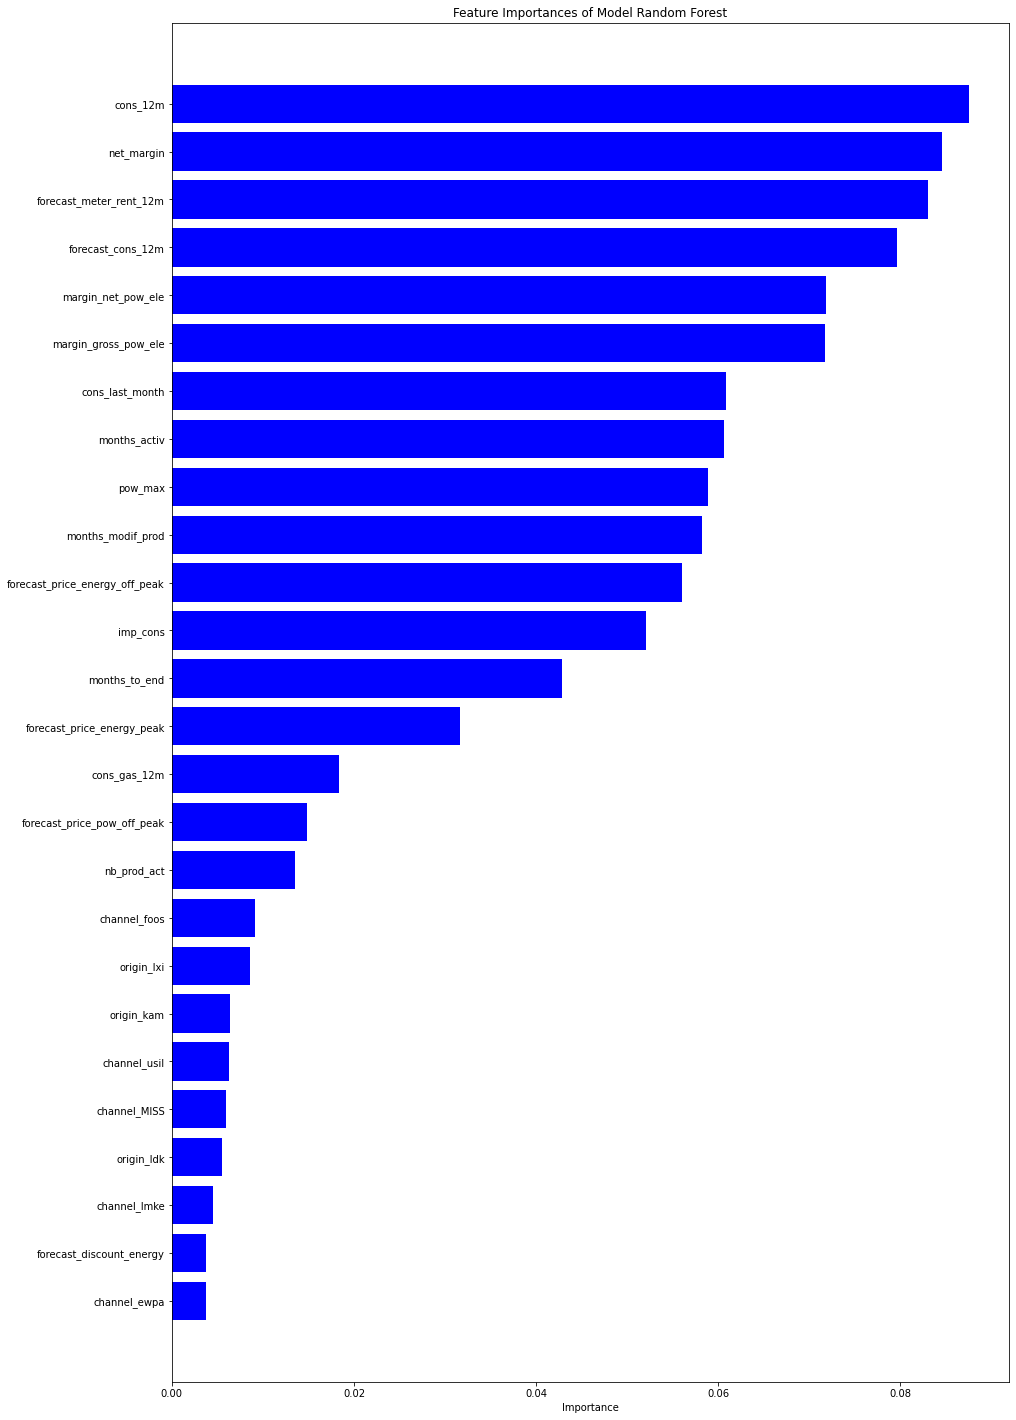

In [37]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances of Model Random Forest')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

In [38]:
import sklearn.metrics as metrics

In [39]:
probs = model_RF.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

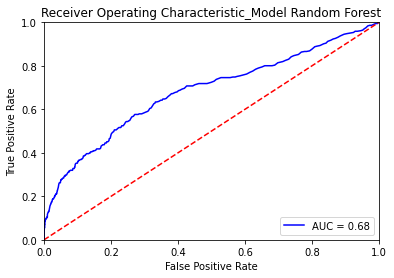

In [40]:
plt.title('Receiver Operating Characteristic_Model Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gradient boosting Model

In [41]:
import xgboost as xgb

In [42]:
model_XGB = xgb.XGBClassifier(learning_rate=0.1,max_depth=15,n_estimators=500,n_jobs=-1,use_label_encoder=False)
result = model_XGB.fit(X_train,y_train)

[21:56:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
def evaluate(model_, X_test_, y_test_):
 
 prediction_test_ = model_.predict(X_test_)
 
 results = pd.DataFrame({"Accuracy" : [metrics.accuracy_score(y_test_, prediction_test_)],
 "Precision" : [metrics.precision_score(y_test_, prediction_test_)],
 "Recall" : [metrics.recall_score(y_test_, prediction_test_)]})
 

 return results

In [44]:
evaluate(model_XGB, X_test, y_test)

,Accuracy,Precision,Recall
0,0.907174,0.662651,0.150273


In [45]:
predictions_XGB = model_XGB.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions_XGB).ravel()

In [46]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions_XGB)}")
print(f"Precision: {metrics.precision_score(y_test, predictions_XGB)}")
print(f"Recall: {metrics.recall_score(y_test, predictions_XGB)}")

True positives: 55
False positives: 28
True negatives: 3258
False negatives: 311

Accuracy: 0.9071741511500547
Precision: 0.6626506024096386
Recall: 0.15027322404371585


In [47]:
feature_importances_xgb = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_XGB.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()


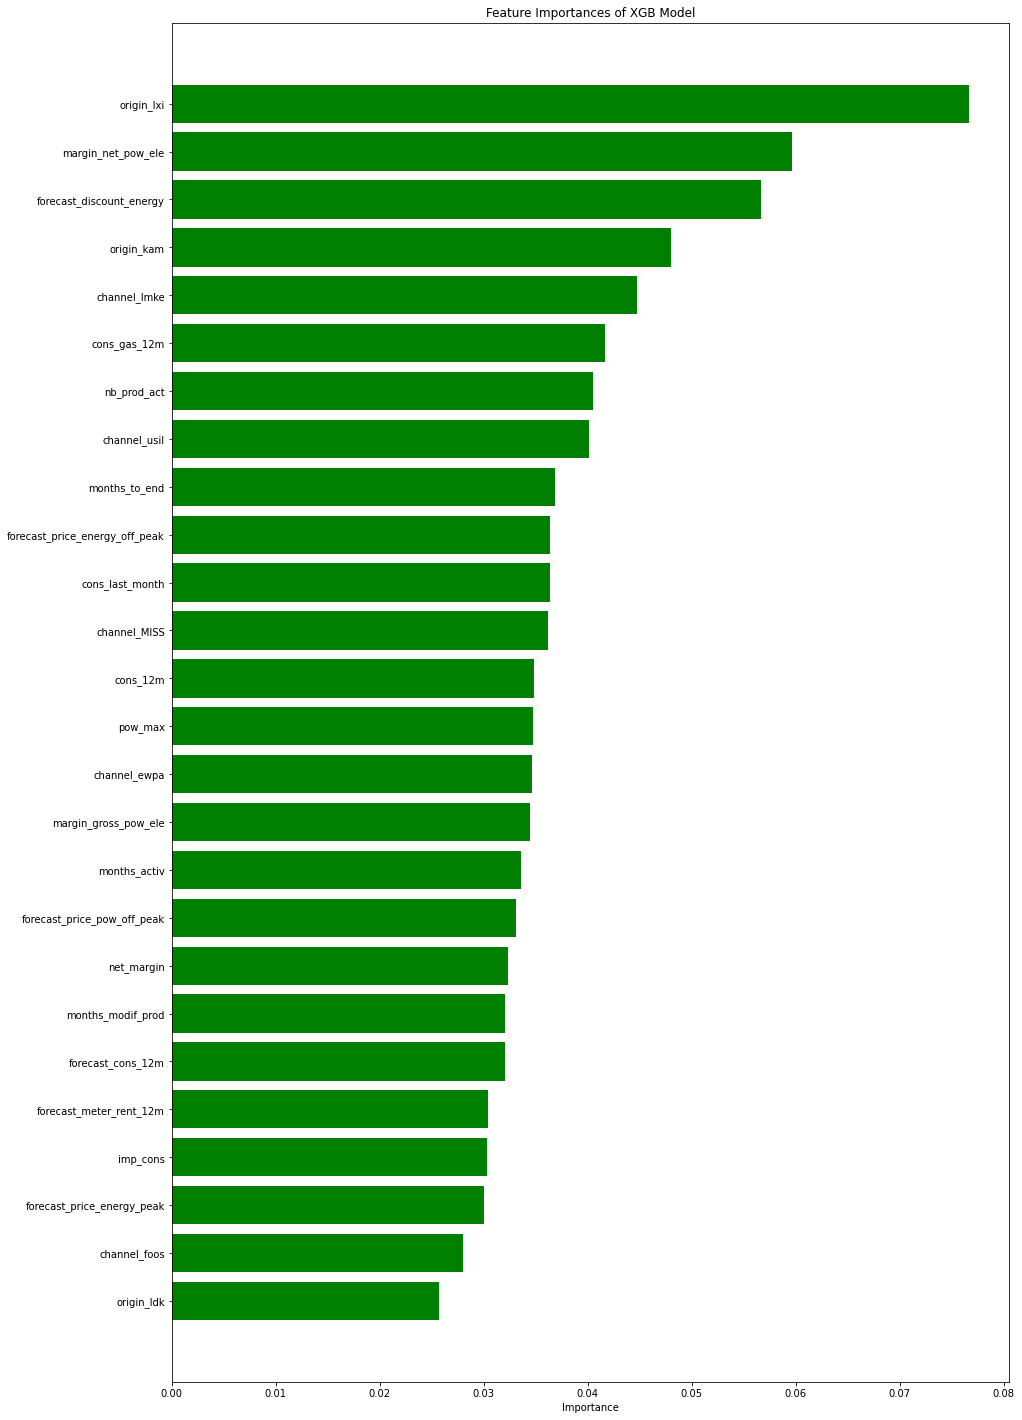

In [48]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances of XGB Model')
plt.barh(range(len(feature_importances_xgb)), feature_importances_xgb['importance'], color='g', align='center')
plt.yticks(range(len(feature_importances_xgb)), feature_importances_xgb['features'])
plt.xlabel('Importance')
plt.show()

In [49]:
probs_XGB = model_XGB.predict_proba(X_test)
preds_XGB = probs_XGB[:,1]
fpr_XGB, tpr_XGB, threshold_XGB = metrics.roc_curve(y_test, preds_XGB)
roc_auc_XGB = metrics.auc(fpr_XGB, tpr_XGB)

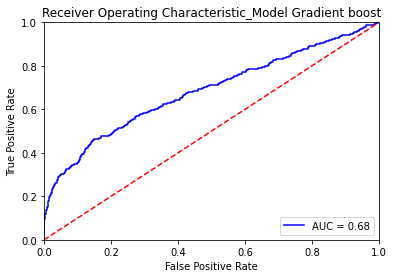

In [50]:
plt.title('Receiver Operating Characteristic_Model Gradient boost')
plt.plot(fpr_XGB, tpr_XGB, 'b', label = 'AUC = %0.2f' % roc_auc_XGB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Future Work

The Gradient boosting model performed slightly better than the Random Forest model in terms of the Recall rate, however it sacrificed the accuracy. 
Hence future work includes: 
1. Get more data from different aspects if possible, for example, customer reviews, complaints data, as those can also influence clients' churn.
2. Review the feature engineering to discover more useful features which may have a greater influence on the prediction model.
3. Review the price history and analyse the root cause of its low predictive power, such as outlier data (lots of prices are 0). Deal with the outliers and re-add price sensitvity back into the prediction model.